In [1]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
import numpy as np
import gower
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform

c:\Users\leo_b\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('./in-vehicle-coupon-recommendation.csv')

#### Drop unnecessary columns and value mapping

In [3]:
df = df.drop(columns=['car'])
df = df.drop(columns=['toCoupon_GEQ5min'])
df = df.drop(columns=['direction_opp'])
df = df.drop_duplicates()

In [4]:
def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df

In [5]:
df = value_mapping(df)

#### Inputation

In [6]:
from sklearn.preprocessing import OrdinalEncoder

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Columns for ordinal encoding
ordinal_cols = ['destination', 'weather', 'time', 'expiration', 'maritalStatus', 'education']

# Define the specific ordering for ordinal columns
ordinal_ordering = {
    'destination': ['No Urgent Place', 'Home', 'Work'],
    'weather': ['Sunny', 'Rainy', 'Snowy'],
    'time': ['7AM', '10AM', '2PM', '6PM', '10PM'],
    'expiration': ['2h', '1d'],
    'maritalStatus': ['Single', 'Unmarried partner', 'Married partner', 'Divorced', 'Widowed'],
    'education': ['Some High School', 'High School Graduate', 'Some college - no degree', 
                  'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']
}

# Ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[ordinal_ordering[col] for col in ordinal_cols])
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# Identify columns to be one-hot encoded (excluding already binary or ordinal encoded columns)
columns_to_encode = df.columns.drop(ordinal_cols + ['temperature', 'age', 'has_children', 'income',
                                                    'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
                                                    'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 
                                                    'direction_same', 'Y'])  # Add any other columns to exclude

# One-hot encoding for the non-binary categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=int)

# df now contains your processed data


In [7]:
original_df = df.copy()

In [8]:
### Code for mode imputation
df_mode = df.copy()

for column in df_mode.columns:
    df_mode[column].fillna(df_mode[column].mode()[0], inplace=True)

In [9]:
columns_to_impute = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
# get columns and subtract columns to impute
columns_to_dummy = list(set(df.columns) - set(columns_to_impute))

# Pass nominal columns to dummy variables
df_clean_dummies = pd.get_dummies(df, columns=columns_to_dummy, drop_first=True)


# Columns to impute
columns_to_impute = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

# Function to impute missing values using Decision Trees
def impute_with_decision_tree(data, column_to_impute, features):
    # Split data into train and predict sets
    train_data = data[data[column_to_impute].notna()]
    predict_data = data[data[column_to_impute].isna()]
    
    # Train a decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(train_data[features], train_data[column_to_impute])
    
    # Predict missing values
    if not predict_data.empty:
        predicted_values = clf.predict(predict_data[features])
        data.loc[data[column_to_impute].isna(), column_to_impute] = predicted_values

    return data

# Features to use for imputation
features = df_clean_dummies.drop(columns=columns_to_impute).columns.tolist()

# Impute missing values for each column
for column in columns_to_impute:
    df_clean_dummies = impute_with_decision_tree(df_clean_dummies, column, features)

# Now substitute NAN values with the values imputeted in df_clean_dummies in df_clean
df['Bar'] = df_clean_dummies['Bar']
df['CoffeeHouse'] = df_clean_dummies['CoffeeHouse']
df['CarryAway'] = df_clean_dummies['CarryAway']
df['RestaurantLessThan20'] = df_clean_dummies['RestaurantLessThan20']
df['Restaurant20To50'] = df_clean_dummies['Restaurant20To50']

# Check if there are still NAN values
df.isna().sum()

destination                                             0
weather                                                 0
temperature                                             0
time                                                    0
expiration                                              0
age                                                     0
maritalStatus                                           0
has_children                                            0
education                                               0
income                                                  0
Bar                                                     0
CoffeeHouse                                             0
CarryAway                                               0
RestaurantLessThan20                                    0
Restaurant20To50                                        0
toCoupon_GEQ15min                                       0
toCoupon_GEQ25min                                       0
direction_same

In [10]:
# Compare coffeehouse column from df_clean and df_clean_mode
print(original_df['CoffeeHouse'].value_counts())
print(df_mode['CoffeeHouse'].value_counts())
print(df['CoffeeHouse'].value_counts())

1.0    3362
2.0    3199
0.0    2946
3.0    1779
4.0    1107
Name: CoffeeHouse, dtype: int64
1.0    3579
2.0    3199
0.0    2946
3.0    1779
4.0    1107
Name: CoffeeHouse, dtype: int64
1.0    3412
2.0    3271
0.0    2947
3.0    1805
4.0    1175
Name: CoffeeHouse, dtype: int64


In [11]:
df['Y']

0        1
1        0
2        1
3        0
4        0
        ..
12679    1
12680    1
12681    0
12682    0
12683    0
Name: Y, Length: 12610, dtype: int64

In [12]:
X = df.drop("Y", axis=1)
y = df["Y"]

In [13]:
for column in X.columns:
    print(f"{column}: {X[column].unique()}")

destination: [0. 1. 2.]
weather: [0. 1. 2.]
temperature: [1 2 0]
time: [2. 1. 3. 0. 4.]
expiration: [1. 0.]
age: [1 6 2 3 5 7 4 0]
maritalStatus: [1. 0. 2. 3. 4.]
has_children: [1 0]
education: [2. 4. 3. 1. 5. 0.]
income: [3 5 1 6 4 2 8 7 0]
Bar: [0. 1. 2. 4. 3.]
CoffeeHouse: [0. 1. 3. 2. 4.]
CarryAway: [2. 3. 4. 1. 0.]
RestaurantLessThan20: [3. 2. 1. 4. 0.]
Restaurant20To50: [2. 1. 0. 4. 3.]
toCoupon_GEQ15min: [0 1]
toCoupon_GEQ25min: [0 1]
direction_same: [0 1]
passanger_Alone: [1 0]
passanger_Friend(s): [0 1]
passanger_Kid(s): [0 1]
passanger_Partner: [0 1]
coupon_Bar: [0 1]
coupon_Carry out & Take away: [0 1]
coupon_Coffee House: [0 1]
coupon_Restaurant(20-50): [0 1]
coupon_Restaurant(<20): [1 0]
gender_Female: [1 0]
gender_Male: [0 1]
occupation_Architecture & Engineering: [0 1]
occupation_Arts Design Entertainment Sports & Media: [0 1]
occupation_Building & Grounds Cleaning & Maintenance: [0 1]
occupation_Business & Financial: [0 1]
occupation_Community & Social Services: [0 1]
o

# Clustering 

In [14]:


#The silhouette score ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
def gower_silhouette_score(X, labels):
    # Compute the Gower distance matrix
    gower_dist_matrix = gower.gower_matrix(X)

    # Initialize variables to store the intra and nearest-cluster distances
    a = np.zeros(X.shape[0])
    b = np.zeros(X.shape[0])

    # Calculate the average intra-cluster distance (a) and the average nearest-cluster distance (b)
    for i in range(X.shape[0]):
        # Same cluster mask
        same_cluster_mask = (labels == labels[i])
        
        # Different cluster mask
        different_cluster_mask = ~same_cluster_mask

        # Intra-cluster distances (a)
        a[i] = np.mean(gower_dist_matrix[i][same_cluster_mask])

        # Nearest-cluster distances (b)
        b[i] = np.min([np.mean(gower_dist_matrix[i][labels == label]) 
                       for label in set(labels) if label != labels[i]])

    # Calculate the silhouette scores
    s = (b - a) / np.maximum(a, b)

    # Return the average silhouette score
    return np.mean(s)

# calculate dunn index for a clustering and gower distance matrix
# The Dunn Index measures the ratio between the smallest distance between observations not in the same cluster to the largest intra-cluster distance.
# A higher value indicates better clustering quality (i.e., clusters are compact and well-separated).
from scipy.spatial.distance import pdist, squareform
import numpy as np

def calculate_dunn_index(distance_matrix, cluster_labels):
    """
    Calculate the Dunn Index for a given clustering.
    
    :param distance_matrix: The precomputed distance matrix (2D squareform format).
    :param cluster_labels: The labels of the clusters for each point.
    :return: The Dunn Index value.
    """
    # Unique cluster labels
    unique_clusters = np.unique(cluster_labels)

    # If there's only one cluster, Dunn Index is not applicable
    if len(unique_clusters) == 1:
        raise ValueError("Dunn Index cannot be calculated for a single cluster")

    # Initialize minimum inter-cluster distance to a large value
    min_inter_cluster_dist = np.inf

    # Initialize maximum intra-cluster distance to 0
    max_intra_cluster_dist = 0

    # Calculate minimum inter-cluster distance
    for i in range(len(unique_clusters)):
        for j in range(i+1, len(unique_clusters)):
            cluster_i = unique_clusters[i]
            cluster_j = unique_clusters[j]
            inter_cluster_distances = distance_matrix[np.ix_(cluster_labels == cluster_i, cluster_labels == cluster_j)]
            min_distance = np.min(inter_cluster_distances)
            if min_distance < min_inter_cluster_dist:
                min_inter_cluster_dist = min_distance

    # Calculate maximum intra-cluster distance
    for cluster in unique_clusters:
        intra_cluster_distances = distance_matrix[np.ix_(cluster_labels == cluster, cluster_labels == cluster)]
        max_distance = np.max(intra_cluster_distances)
        if max_distance > max_intra_cluster_dist:
            max_intra_cluster_dist = max_distance

    # Calculate Dunn Index
    dunn_index = min_inter_cluster_dist / max_intra_cluster_dist

    return dunn_index


# calculate davies bouldin index for a clustering and gower distance matrix
# Lower values are preferred, indicating that clusters are farther apart and less dispersed.
def davies_bouldin_index(X, labels):
    # Compute the Gower distance matrix
    gower_dist_matrix = gower.gower_matrix(X)

    # Initialize variables to store the intra and nearest-cluster distances
    a = np.zeros(X.shape[0])
    b = np.zeros(X.shape[0])

    # Calculate the average intra-cluster distance (a) and the average nearest-cluster distance (b)
    for i in range(X.shape[0]):
        # Same cluster mask
        same_cluster_mask = (labels == labels[i])
        
        # Different cluster mask
        different_cluster_mask = ~same_cluster_mask

        # Intra-cluster distances (a)
        a[i] = np.mean(gower_dist_matrix[i][same_cluster_mask])

        # Nearest-cluster distances (b)
        b[i] = np.min([np.mean(gower_dist_matrix[i][labels == label]) 
                       for label in set(labels) if label != labels[i]])

    # Calculate the Davies-Bouldin index
    db_index = np.mean((a + b) / np.max(b))

    # Return the Davies-Bouldin index
    return db_index

### Hierarchical Clustering

In [15]:
def normalize_score(score, score_min, score_max):
    """ Normalize a score to a 0-1 scale. """
    return (score - score_min) / (score_max - score_min)

Average Gower Silhouette Score: 0.15741446614265442
Dunn Index: 0.20361991226673126
Davies-Bouldin Index: 0.7710123654873479
Metrics for Single Linkage with 2 clusters:
Contingency Matrix:
[[5452    1]
 [7157    0]]
Number of Clusters: 2
Samples per Cluster: [12609     1]
Composite Score (Normalized): 0.5752742774360052


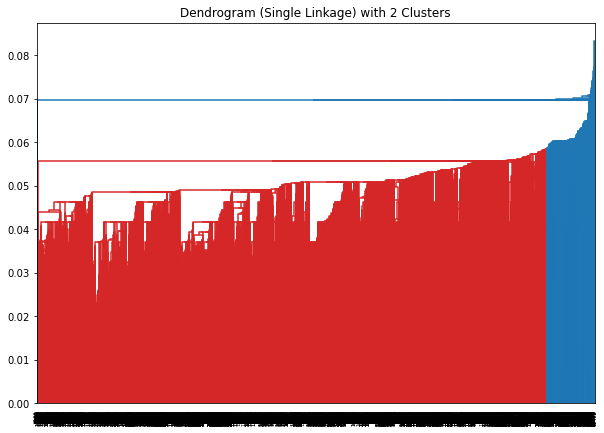

Average Gower Silhouette Score: 0.10059972107410431
Dunn Index: 0.19230768084526062
Davies-Bouldin Index: 0.7753169863258799
Metrics for Single Linkage with 3 clusters:
Contingency Matrix:
[[5451    1    1]
 [7157    0    0]]
Number of Clusters: 3
Samples per Cluster: [12608     1     1]
Composite Score (Normalized): 0.5578953752905224


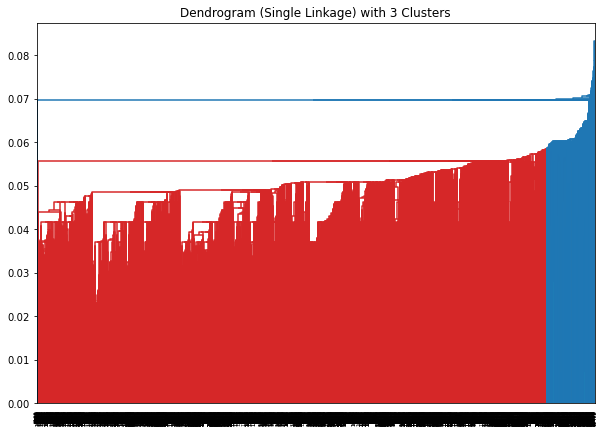

Average Gower Silhouette Score: 0.05910649523139
Dunn Index: 0.18891403079032898
Davies-Bouldin Index: 0.8893100671739823
Metrics for Single Linkage with 4 clusters:
Contingency Matrix:
[[   2 5449    1    1]
 [   2 7155    0    0]]
Number of Clusters: 4
Samples per Cluster: [    4 12604     1     1]
Composite Score (Normalized): 0.5392762926133472


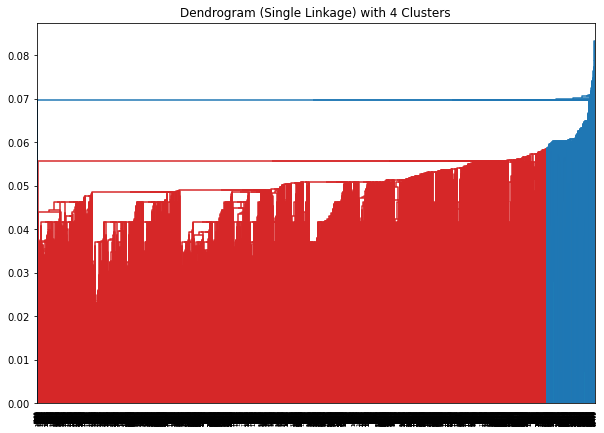

Average Gower Silhouette Score: 0.07641097903251648
Dunn Index: 0.057765305042266846
Davies-Bouldin Index: 6.4018996255566005
Metrics for Complete Linkage with 2 clusters:
Contingency Matrix:
[[1864 3589]
 [1698 5459]]
Number of Clusters: 2
Samples per Cluster: [3562 9048]
Composite Score (Normalized): 0.2475688262790706


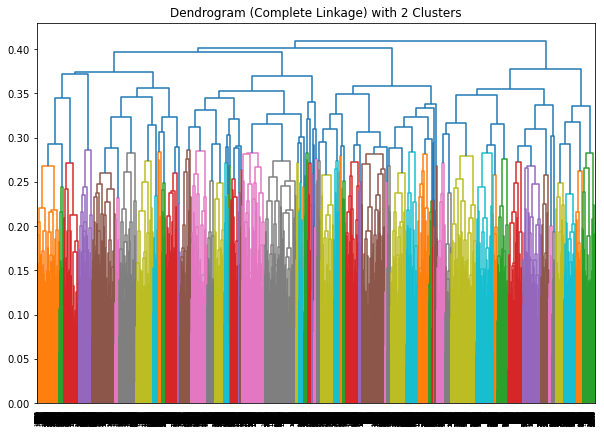

Average Gower Silhouette Score: 0.04120802879333496
Dunn Index: 0.041659723967313766
Davies-Bouldin Index: 7.203984298495804
Metrics for Complete Linkage with 3 clusters:
Contingency Matrix:
[[1864 1123 2466]
 [1698 1589 3870]]
Number of Clusters: 3
Samples per Cluster: [3562 2712 6336]
Composite Score (Normalized): 0.21535655176361826


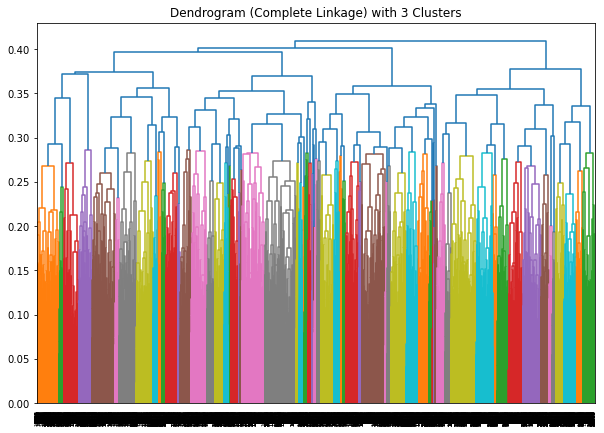

Average Gower Silhouette Score: 0.02045534923672676
Dunn Index: 0.04384426400065422
Davies-Bouldin Index: 7.93277700804921
Metrics for Complete Linkage with 4 clusters:
Contingency Matrix:
[[1864 1123 1203 1263]
 [1698 1589 1889 1981]]
Number of Clusters: 4
Samples per Cluster: [3562 2712 3092 3244]
Composite Score (Normalized): 0.20044278356992296


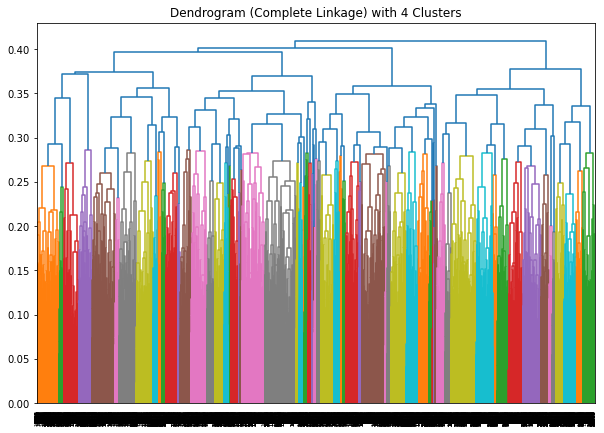

Average Gower Silhouette Score: 0.12472216039896011
Dunn Index: 0.07162623852491379
Davies-Bouldin Index: 6.948048210722986
Metrics for Weighted Linkage with 2 clusters:
Contingency Matrix:
[[2424 3029]
 [3552 3605]]
Number of Clusters: 2
Samples per Cluster: [5976 6634]
Composite Score (Normalized): 0.25406136666850393


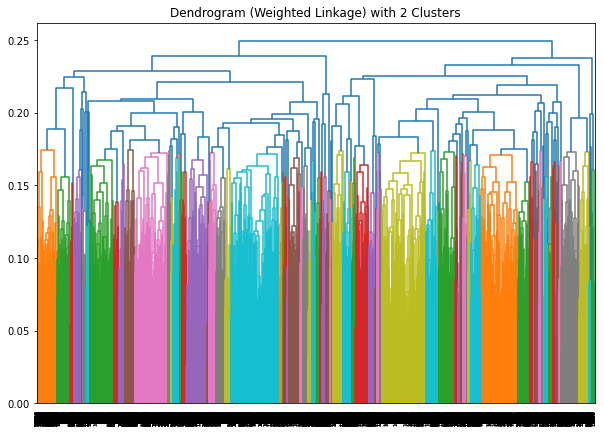

Average Gower Silhouette Score: 0.09658623486757278
Dunn Index: 0.07162623852491379
Davies-Bouldin Index: 6.128826969944974
Metrics for Weighted Linkage with 3 clusters:
Contingency Matrix:
[[2424   68 2961]
 [3552  164 3441]]
Number of Clusters: 3
Samples per Cluster: [5976  232 6402]
Composite Score (Normalized): 0.2658746358799568


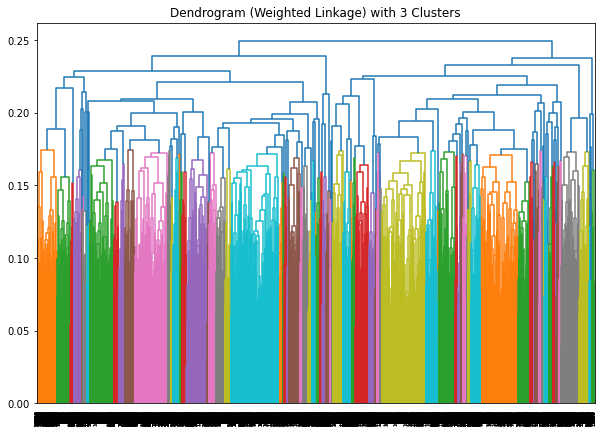

Average Gower Silhouette Score: 0.07543880492448807
Dunn Index: 0.07162623852491379
Davies-Bouldin Index: 4.996601905131047
Metrics for Weighted Linkage with 4 clusters:
Contingency Matrix:
[[  42 2382   68 2961]
 [  74 3478  164 3441]]
Number of Clusters: 4
Samples per Cluster: [ 116 5860  232 6402]
Composite Score (Normalized): 0.2885882774492742


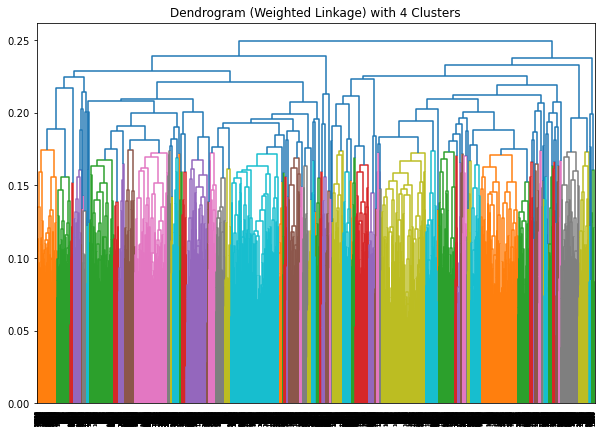

Average Gower Silhouette Score: 0.08914565294981003
Dunn Index: 0.12443438917398453
Davies-Bouldin Index: 1.0872429453308488
Metrics for Centroid Linkage with 2 clusters:
Contingency Matrix:
[[   2 5451]
 [   3 7154]]
Number of Clusters: 2
Samples per Cluster: [    5 12605]
Composite Score (Normalized): 0.4861815181132004


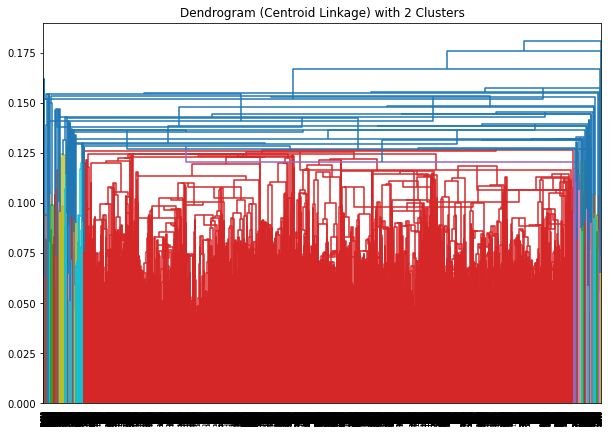

Average Gower Silhouette Score: 0.03601405397057533
Dunn Index: 0.12443438917398453
Davies-Bouldin Index: 1.2883610848582265
Metrics for Centroid Linkage with 3 clusters:
Contingency Matrix:
[[   2    6 5445]
 [   3    2 7152]]
Number of Clusters: 3
Samples per Cluster: [    5     8 12597]
Composite Score (Normalized): 0.46337048690268684


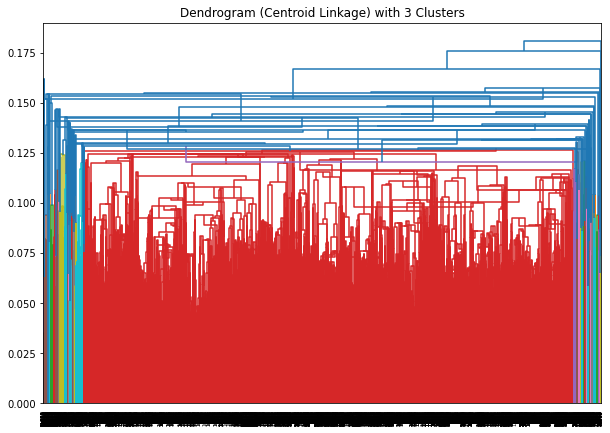

Average Gower Silhouette Score: -0.03561502695083618
Dunn Index: 0.12443438917398453
Davies-Bouldin Index: 1.2423584621246766
Metrics for Centroid Linkage with 4 clusters:
Contingency Matrix:
[[   2    6    0 5445]
 [   3    2    2 7150]]
Number of Clusters: 4
Samples per Cluster: [    5     8     2 12595]
Composite Score (Normalized): 0.45451311472757294


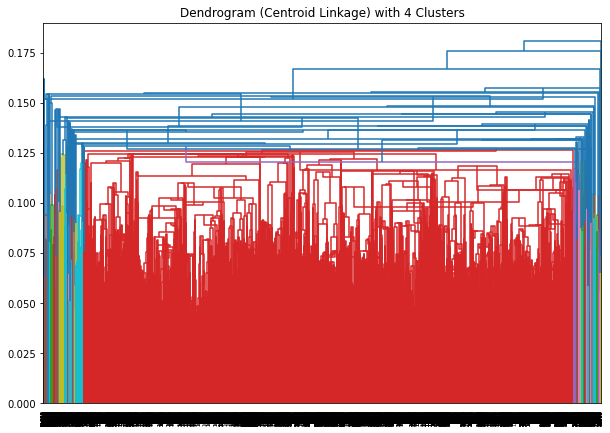

Average Gower Silhouette Score: 0.11949552595615387
Dunn Index: 0.05684586241841316
Davies-Bouldin Index: 5.81568882500431
Metrics for Ward Linkage with 2 clusters:
Contingency Matrix:
[[2070 3383]
 [3411 3746]]
Number of Clusters: 2
Samples per Cluster: [5481 7129]
Composite Score (Normalized): 0.2666538587764552


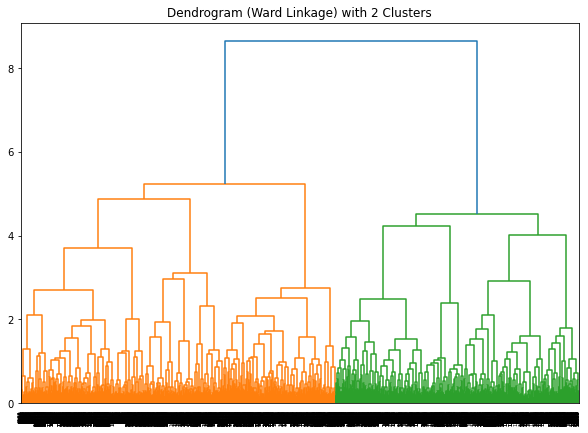

Average Gower Silhouette Score: 0.0755009651184082
Dunn Index: 0.057765305042266846
Davies-Bouldin Index: 6.888109763062649
Metrics for Ward Linkage with 3 clusters:
Contingency Matrix:
[[2070 1010 2373]
 [3411 1554 2192]]
Number of Clusters: 3
Samples per Cluster: [5481 2564 4565]
Composite Score (Normalized): 0.23776560875464053


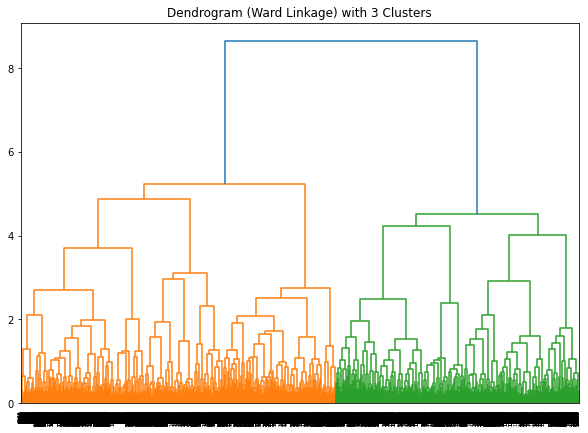

Average Gower Silhouette Score: 0.06590330600738525
Dunn Index: 0.05787036940455437
Davies-Bouldin Index: 6.51688286008455
Metrics for Ward Linkage with 4 clusters:
Contingency Matrix:
[[2070 1010 1024 1349]
 [3411 1554  753 1439]]
Number of Clusters: 4
Samples per Cluster: [5481 2564 1777 2788]
Composite Score (Normalized): 0.24354905450218295


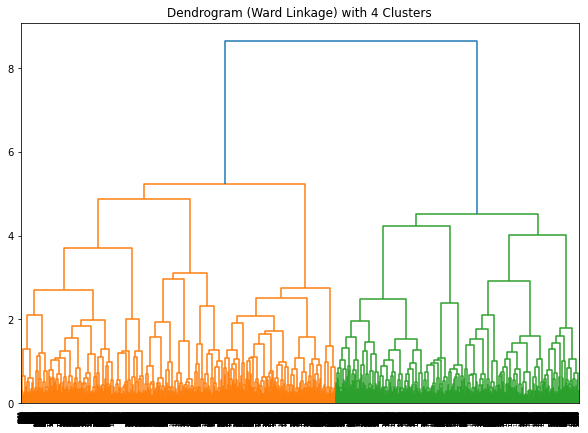

In [16]:
# Calculate the Gower distance matrix
gower_dist_matrix = gower.gower_matrix(X)

# Convert the Gower distance matrix to a condensed distance matrix
condensed_gower_dist_matrix = squareform(gower_dist_matrix)

linkage_methods = ['single', 'complete', 'weighted', 'centroid', 'ward']
n_clusters_range = range(2, 5)  # Example: considering 2 to 4 clusters
# Store scores for each k
scores = []

for method in linkage_methods:
    # Perform hierarchical clustering using the condensed Gower distance matrix
    linked = linkage(condensed_gower_dist_matrix, method=method)
    
    for n_clusters in n_clusters_range:
        # Obtain cluster labels
        y_pred = fcluster(linked, n_clusters, criterion='maxclust') 
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(gower_dist_matrix
                                            ,y_pred, metric='precomputed') #gower_silhouette_score(X, y_pred)
        print(f"Average Gower Silhouette Score: {silhouette_avg}")
        # Calculate Dunn Index
        dunn_index_score = calculate_dunn_index(gower_dist_matrix, y_pred)
        print(f"Dunn Index: {dunn_index_score}")
        # Calculate Davies-Bouldin Index
        db_index = davies_bouldin_score(X, y_pred) #davies_bouldin_index(X, y_pred)
        print(f"Davies-Bouldin Index: {db_index}")

        # Print contingency matrix and other metrics
        print(f"Metrics for {method.capitalize()} Linkage with {n_clusters} clusters:")
        print(f"Contingency Matrix:\n{metrics.cluster.contingency_matrix(y, y_pred)}")
        print(f"Number of Clusters: {np.unique(y_pred).size}")
        print(f"Samples per Cluster: {np.unique(y_pred, return_counts=True)[1]}")
        
        ### Calculate composite score
        # Normalizing Silhouette Score (range [-1, 1] to [0, 1])
        normalized_silhouette = normalize_score(silhouette_avg, -1, 1)

        # Normalizing Dunn Index (Assuming a maximum reasonable value for normalization)
        # This maximum value is an assumption and should be adjusted based on domain knowledge
        max_reasonable_dunn = 0.5  # Example value, adjust based on your data
        davies_bouldin_index = 8
        normalized_dunn = normalize_score(dunn_index_score, 0, max_reasonable_dunn)

        # Normalizing Davies-Bouldin Index (using a logarithmic scale due to high values)
        # We add 1 to avoid log(0) in case of a DB index of 0
        normalized_davies_bouldin = 1 - np.log(1 + db_index) / np.log(1 + max(db_index, davies_bouldin_index))

        # Assuming equal weights for simplicity, but these can be adjusted
        weight_silhouette = 1/3
        weight_dunn = 1/3
        weight_davies_bouldin = 1/3

        # Calculating weighted average
        composite_score_normalized = (weight_silhouette * normalized_silhouette + 
                                    weight_dunn * normalized_dunn + 
                                    weight_davies_bouldin * normalized_davies_bouldin)
        print(f"Composite Score (Normalized): {composite_score_normalized}")

        # Plot the dendrogram
        plt.figure(figsize=(10, 7))
        dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
        plt.title(f"Dendrogram ({method.capitalize()} Linkage) with {n_clusters} Clusters")
        plt.show()

Average Gower Silhouette Score: 0.08936332911252975
Dunn Index: 0.09049773961305618
Davies-Bouldin Index: 1.6744788249239373
Metrics for Average Linkage with 2 clusters:
Contingency Matrix:
[[  51 5402]
 [  91 7066]]
Number of Clusters: 2
Samples per Cluster: [  142 12468]
Composite Score (Normalized): 0.4259837208976512


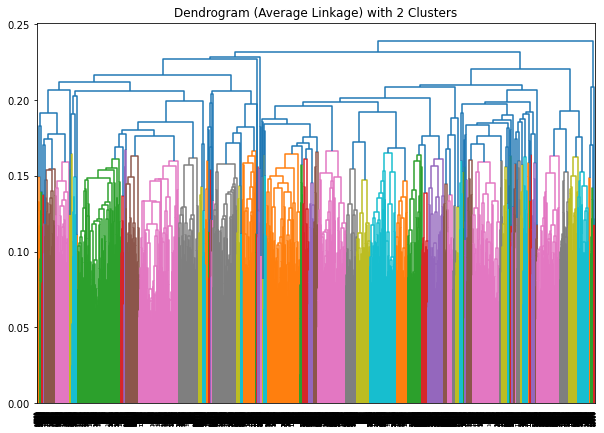

Average Gower Silhouette Score: 0.09556964784860611
Dunn Index: 0.0843254029750824
Davies-Bouldin Index: 4.3878939642197246
Metrics for Average Linkage with 3 clusters:
Contingency Matrix:
[[  51 3519 1883]
 [  91 3881 3185]]
Number of Clusters: 3
Samples per Cluster: [ 142 7400 5068]
Composite Score (Normalized): 0.3166479498029052


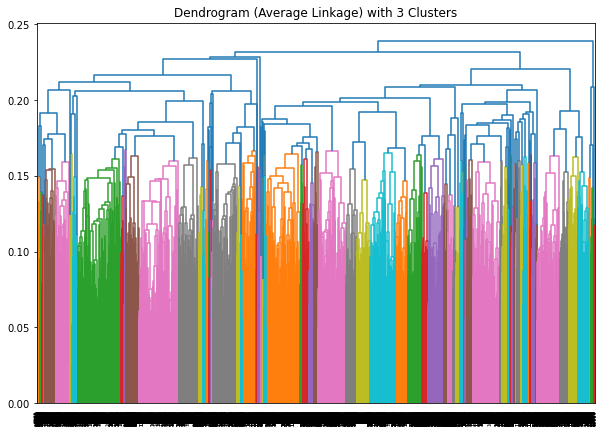

Average Gower Silhouette Score: 0.06596536189317703
Dunn Index: 0.0843254029750824
Davies-Bouldin Index: 3.982232805575256
Metrics for Average Linkage with 4 clusters:
Contingency Matrix:
[[  51 3519   28 1855]
 [  91 3881   36 3149]]
Number of Clusters: 4
Samples per Cluster: [ 142 7400   64 5004]
Composite Score (Normalized): 0.32358894882514333


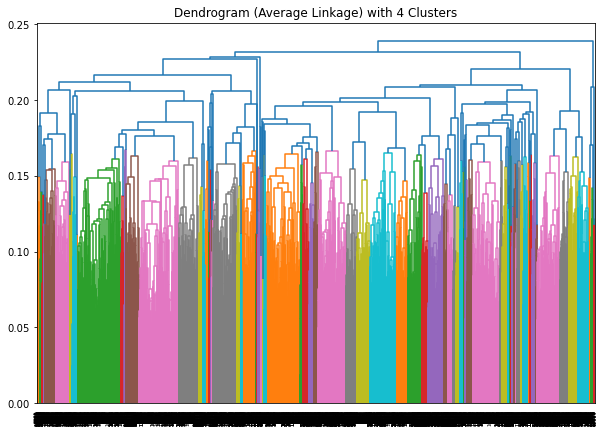

In [17]:
# Calculate the Gower distance matrix
gower_dist_matrix = gower.gower_matrix(X)

# Convert the Gower distance matrix to a condensed distance matrix
condensed_gower_dist_matrix = squareform(gower_dist_matrix)

linkage_methods = ['average']
n_clusters_range = range(2, 5)  # Example: considering 2 to 4 clusters
# Store scores for each k
scores = []

for method in linkage_methods:
    # Perform hierarchical clustering using the condensed Gower distance matrix
    linked = linkage(condensed_gower_dist_matrix, method=method)
    
    for n_clusters in n_clusters_range:
        # Obtain cluster labels
        y_pred = fcluster(linked, n_clusters, criterion='maxclust') 
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(gower_dist_matrix
                                            ,y_pred, metric='precomputed') #gower_silhouette_score(X, y_pred)
        print(f"Average Gower Silhouette Score: {silhouette_avg}")
        # Calculate Dunn Index
        dunn_index_score = calculate_dunn_index(gower_dist_matrix, y_pred)
        print(f"Dunn Index: {dunn_index_score}")
        # Calculate Davies-Bouldin Index
        db_index = davies_bouldin_score(X, y_pred) #davies_bouldin_index(X, y_pred)
        print(f"Davies-Bouldin Index: {db_index}")

        # Print contingency matrix and other metrics
        print(f"Metrics for {method.capitalize()} Linkage with {n_clusters} clusters:")
        print(f"Contingency Matrix:\n{metrics.cluster.contingency_matrix(y, y_pred)}")
        print(f"Number of Clusters: {np.unique(y_pred).size}")
        print(f"Samples per Cluster: {np.unique(y_pred, return_counts=True)[1]}")
        
        ### Calculate composite score
        # Normalizing Silhouette Score (range [-1, 1] to [0, 1])
        normalized_silhouette = normalize_score(silhouette_avg, -1, 1)

        # Normalizing Dunn Index (Assuming a maximum reasonable value for normalization)
        # This maximum value is an assumption and should be adjusted based on domain knowledge
        max_reasonable_dunn = 0.5  # Example value, adjust based on your data
        davies_bouldin_index = 8
        normalized_dunn = normalize_score(dunn_index_score, 0, max_reasonable_dunn)

        # Normalizing Davies-Bouldin Index (using a logarithmic scale due to high values)
        # We add 1 to avoid log(0) in case of a DB index of 0
        normalized_davies_bouldin = 1 - np.log(1 + db_index) / np.log(1 + max(db_index, davies_bouldin_index))

        # Assuming equal weights for simplicity, but these can be adjusted
        weight_silhouette = 1/3
        weight_dunn = 1/3
        weight_davies_bouldin = 1/3

        # Calculating weighted average
        composite_score_normalized = (weight_silhouette * normalized_silhouette + 
                                    weight_dunn * normalized_dunn + 
                                    weight_davies_bouldin * normalized_davies_bouldin)
        print(f"Composite Score (Normalized): {composite_score_normalized}")

        # Plot the dendrogram
        plt.figure(figsize=(10, 7))
        dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
        plt.title(f"Dendrogram ({method.capitalize()} Linkage) with {n_clusters} Clusters")
        plt.show()

Atualizei sim
